<a href="https://colab.research.google.com/github/Sshubam/FSM_ML_Assignments/blob/main/FSM_3_KMeans_PCA_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


# Loading and Preprocessing our Data


---



In [772]:
import numpy as np
import numpy.matlib
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [773]:
idf = pd.read_csv("Iris Dataset.csv")
idf.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [774]:
# Normalizing our Data to obtain a normal distribution so that our data is scaled

idf['SepalWidthCm'] = (idf['SepalWidthCm'] - idf['SepalWidthCm'].mean() ) / idf['SepalWidthCm'].std()
idf['PetalWidthCm'] = (idf['PetalWidthCm'] - idf['PetalWidthCm'].mean() ) / idf['PetalWidthCm'].std()
idf['SepalLengthCm'] = (idf['SepalLengthCm'] - idf['SepalLengthCm'].mean() ) / idf['SepalLengthCm'].std()
idf['PetalLengthCm'] = (idf['PetalLengthCm'] - idf['PetalLengthCm'].mean() ) / idf['PetalLengthCm'].std()

In [775]:
# Label encoding our classes to feed into our model
idf['Species'] = idf['Species'].map({'Iris-setosa': 1, 'Iris-versicolor' : 2, 'Iris-virginica' : 3})

In [776]:
idf.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,-0.897674,1.028611,-1.336794,-1.308593,1
1,2,-1.139200,-0.124540,-1.336794,-1.308593,1
2,3,-1.380727,0.336720,-1.393470,-1.308593,1
3,4,-1.501490,0.106090,-1.280118,-1.308593,1
4,5,-1.018437,1.259242,-1.336794,-1.308593,1


In [777]:
idf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    int64  
dtypes: float64(4), int64(2)
memory usage: 7.2 KB




---


# Exploratory Data Analysis 


---



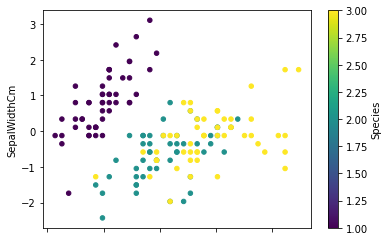

In [778]:
idf.plot.scatter(x = 'SepalLengthCm', y = 'SepalWidthCm', c = 'Species', colormap = 'viridis')
plt.show()

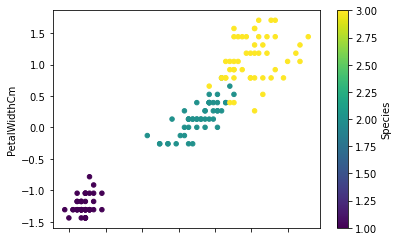

In [779]:
idf.plot.scatter(x = 'PetalLengthCm', y = 'PetalWidthCm', c = 'Species', colormap = 'viridis')
plt.show()

**From the above Exploratory Data Analysis we can observe :**

*    Flowers having higheest Sepal width and height are generally Iris-setosa (class 1)
*    Flowers having lowest sepal width and height, generally are Iris-versicolor (class 2)
*    Flowers having medium sepal width and height are generally Iris-virginica (class 3)


*   Flowers having lowest Petal width and height are generally Iris-setosa (class 1)
*   Flowers having medium Petal width and height are generally Iris-versicolor (class 2)
*   Flowers having highest Petal width and height are generally Iris-virginica (class 3)









---


# KMeans Clustering


---



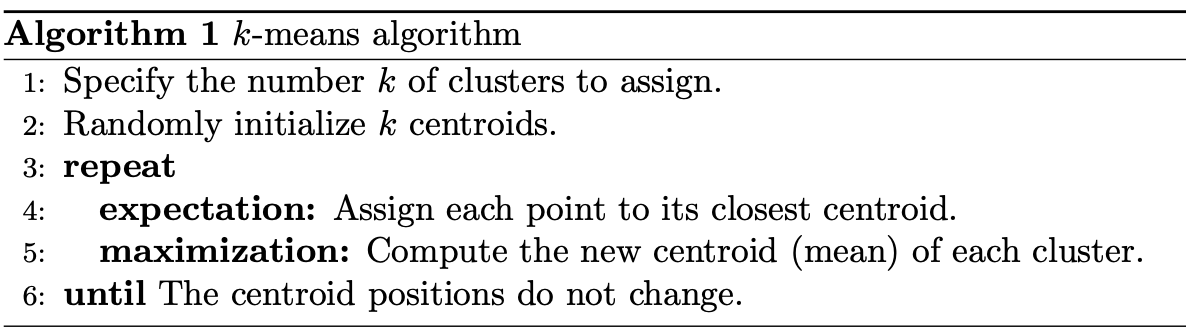

In [780]:
cluster_data = idf[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']].copy(deep=True)
cluster_data.dropna(axis = 0, inplace = True)
cluster_data.sort_values(by=['SepalLengthCm',	'SepalWidthCm',	'PetalLengthCm'	,'PetalWidthCm'], inplace=True)
cluster_array = np.array(cluster_data)

In [781]:
# Calculate distance between two datapoints
def distance(p1, p2):
  return (sum((p1 - p2) ** 2)) ** 0.5

In [782]:
# Allot clusters based on nearest centroid
def allot_clusters(centroids, cluster_array):
  clusters = []
  for i in range(cluster_array.shape[0]):
    distances_list = []
    for centroid in centroids:
      distances_list.append(distance(centroid, cluster_array[i]))
    cluster = [z for z, val in enumerate(distances_list) if val == min(distances_list)]
    clusters.append(cluster[0])
  return clusters

In [783]:
# Calculate new centroids based on each cluster's mean
def calc_centroids(clusters, cluster_array):
  new_centroids = []
  cluster_df = pd.concat([pd.DataFrame(cluster_array), pd.DataFrame(clusters, columns = ['cluster'])], axis=1)
  for c in set(cluster_df['cluster']):
    current_cluster = cluster_df[cluster_df['cluster'] == c][cluster_df.columns[:-1]]
    cluster_mean = current_cluster.mean(axis=0)
    new_centroids.append(cluster_mean)
  return new_centroids

In [784]:
# Calculate variance within each cluster
def calculate_centroid_variance(clusters, cluster_array):
  sum_squares = []
  cluster_df = pd.concat([pd.DataFrame(cluster_array), pd.DataFrame(clusters, columns=['cluster'])], axis=1)
  for c in set(cluster_df['cluster']):
    current_cluster = cluster_df[cluster_df['cluster'] == c][cluster_df.columns[:-1]]
    cluster_mean = current_cluster.mean(axis=0)
    mean_repmat = np.matlib.repmat(cluster_mean, current_cluster.shape[0], 1)
    sum_squares.append(np.sum(np.sum((current_cluster - mean_repmat) ** 2)))
  return sum_squares

In [785]:
# Since we have 3 classes, we will set the value of k = 3 to make 3 clusters
k = 3
cluster_variances = []
centroids = [cluster_array[i+2] for i in range(k)]
clusters = allot_clusters(centroids, cluster_array)
initial_clusters = clusters
print(round(np.mean(calculate_centroid_variance(clusters, cluster_array))))
for i in range(5):
  centroids = calc_centroids(clusters, cluster_array)
  clusters = allot_clusters(centroids, cluster_array)
  cluster_variance = np.mean(calculate_centroid_variance(clusters, cluster_array))
  cluster_variances.append(cluster_variance)
  print((cluster_variance))

143
55.914400785901165
47.90013175116709
47.1417662426765
46.96964276582292
46.8619972501236


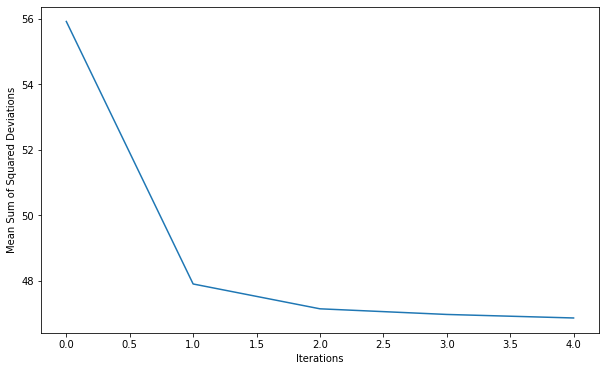

In [786]:
plt.subplots(figsize=(10, 6))
plt.plot(cluster_variances)
plt.xlabel('Iterations')
plt.ylabel('Mean Sum of Squared Deviations');

NameError: ignored

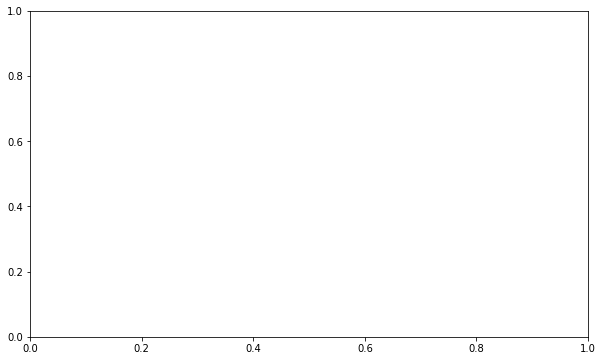

In [787]:
plt.subplots(figsize=(10, 6))
plt.scatter(x = cluster_array[:, 0], y = cluster_array[:, 1], c = Initial_clusters, cmap = plt.cm.copper)
plt.title("Initial cluster")
plt.show()

In [ ]:
plt.subplots(figsize=(10, 6))
plt.scatter(x = cluster_array[:, 0], y = cluster_array[:, 1], c = clusters, cmap = plt.cm.copper)
plt.title("Final cluster")
plt.show()

In [ ]:
results_df = cluster_data.join(idf[['Species']], how = 'left').reset_index(drop = True)
results_df = pd.concat([results_df, pd.DataFrame(initial_clusters, columns=['initial_cluster']), pd.DataFrame(clusters, columns=['converged_cluster'])], axis = 1)

In [ ]:
results_df

In [ ]:
pivot_initial = (results_df.pivot_table(values=['Species'], index=['initial_cluster'], aggfunc='mean'))
pivot_initial['label'] = ['Initial' for i in range(pivot_initial.shape[0])]

pivot_converged = results_df.pivot_table(values=['Species'], index=['converged_cluster'], aggfunc='mean')
pivot_converged['label'] = ['Converged' for i in range(pivot_converged.shape[0])]

pivot_df = pd.concat([pivot_initial, pivot_converged], axis=0).reset_index()
pivot_df = pivot_df.rename({'index': 'Cluster', 'Species': 'Species name'}, axis=1)
results_df['converged_cluster'] = results_df['converged_cluster'].map({1: 1, 2: 2, 0: 3})

In [ ]:
results_df.head()

In [ ]:
conditions = [results_df['Species'] == results_df['converged_cluster']]
choices = ['True']
results_df['true_pred'] = np.select(conditions, choices, default='False')
results_df.head()

In [ ]:
results_df['true_pred'].value_counts('True')



---


# Principal Component Analysis


---



**For implementing the PCA Algorithm :**

> First we standardized our Data so our data is scaled to a comon range, so that our model is not biased towards higher values

> Next we create the covariance matrix for our features to check relationships between them

> Then we calculate the eigenvectors and eigenvalues for the covariance matrix to compute principal components

> We sort the eigenvalues and the corresponding eigenvectors and pick first k eigenvalues

> Then we take dot product of our original data with the eigenvectors to get the projections of the data in the direction of our eigenvectors











In [ ]:
class PCA(object):
  def __init__(self, n_components : int = None):
    self.n_components = n_components

  def fit_transform(self, X : np.ndarray):
    if not self.n_components:
      self.n_components = min(X.shape)
    self.covariance_ = np.cov(X.T)

    # calculate eigen vectors and values
    self.eig_vals, self.eig_vecs = np.linalg.eig(self.covariance_)

    # explained variance
    _tot_eig_vals = sum(self.eig_vals)
    self.explained_variance = np.array([(i / _tot_eig_vals) * 100 for i in sorted(self.eig_vals, reverse = True)])
    self.cum_explained_variance = np.cumsum(self.explained_variance)

    # W = original features x desired features dimension
    self.W_ = self.eig_vecs[:, :self.n_components]
    print(X.shape, self.W_.shape)
    return X.dot(self.W_)

In [ ]:
X = idf[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
X = MinMaxScaler().fit_transform(X)
y = idf[['Species']]

# Calling our PCA Function
PCA = PCA()
principalComponents = PCA.fit_transform(X)

# creating a df for the principalcomponents
PCAResult = pd.DataFrame(principalComponents, columns = [f"PCA-{i}" for i in range(1, PCA.n_components + 1)])
PCAResult["target"] = y 

plt.subplots(figsize=(10, 6))
plt.scatter(x="PCA-1", y="PCA-2", data = PCAResult, cmap = 'copper', c = 'target')
plt.show()

In [ ]:
PCA.eig_vals

In [ ]:
PCA.eig_vecs